In [37]:
import os
import torch
import math
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 2.3.1+cu121 with cuda 12.1


In [38]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html


In [39]:
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, radius_graph
from torch_geometric.utils import add_self_loops
import torch_cluster
import torch_scatter
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")


from torch.utils.tensorboard import SummaryWriter
os.makedirs('train_log', exist_ok=True)
os.makedirs('rollouts', exist_ok=True)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PyTorch has version 2.3.1+cu121 with cuda 12.1


In [40]:
print(np.__version__)

1.25.2


In [ ]:
# start coding with numpy==1.23.1
# !pip uninstall numpy -y
# !pip install numpy==1.23.1

In [41]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [42]:
import tree
from tqdm import tqdm

In [43]:
import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds

First, create a function to generate a graph from raw data.

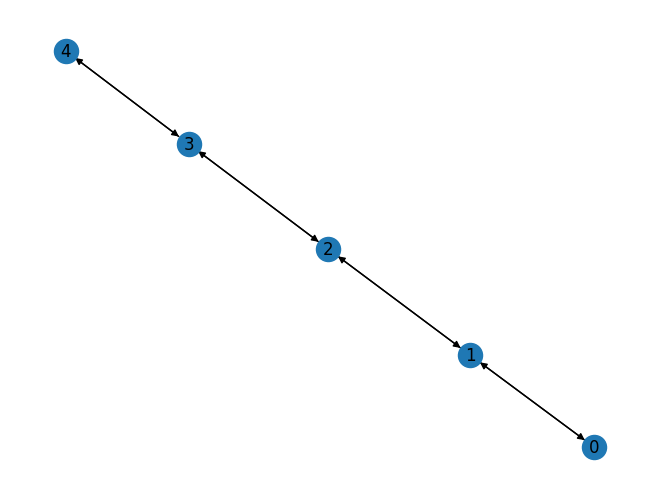

tensor([[ 1.0000, -1.0000,  0.0000,  0.4709],
        [ 1.0000,  1.0000,  0.0000,  5.9367],
        [ 1.0000, -1.0000,  0.0000,  0.1412],
        [ 1.0000,  1.0000,  0.0000,  4.0954],
        [ 1.0000, -1.0000,  0.0000,  5.8849],
        [ 1.0000,  1.0000,  0.0000,  9.3113],
        [ 1.0000, -1.0000,  0.0000,  2.9669],
        [ 1.0000,  1.0000,  0.0000,  9.0533]])


In [44]:
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph

def create_gnn_graph(coordinates, metadata):
    """
    Create a graph data object for a GNN model.

    Args:
    - coordinates (list of tuples): A list of 2D coordinates for each node.
    - E_initial (float): The initial value for the edge attribute.

    Returns:
    - data (Data): A PyG Data object representing the graph.
    """

    # Convert coordinates to tensor
    node_features = torch.tensor(coordinates, dtype=torch.float)

    # Add the load as a node attribute
    load = torch.rand(node_features.size(0), 1) * metadata["P_initial"]
    dist_boundary = torch.norm(node_features - torch.tensor([[0, 0]], dtype=torch.float), dim=1).unsqueeze(1)

    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(node_features, r=metadata["default_connectivity_radius"], loop=False)

    # Calculate edge attributes (e.g., Euclidean distance)
    distance = torch.norm(node_features[edge_index[0]] - node_features[edge_index[1]], dim=1).unsqueeze(1)
    # Calculate displacement as vector at each edge
    displacement = (node_features[edge_index[1]] - node_features[edge_index[0]])

    # Convert E_initial to a PyTorch tensor
    E_initial = torch.tensor(metadata["E_initial"], dtype=torch.float)
    # Correctly generate a tensor with random values uniformly distributed between 0 and 1, then scale by E_initial
    E_edge = torch.rand(edge_index.size(1), 1) * E_initial

    # Now, both tensors have shape [number_of_edges, 1] and can be concatenated
    edge_attr = torch.cat([distance, displacement, E_edge], dim=1)

    # Create a graph data object
    graph_data = Data(pos=node_features, edge_index=edge_index, edge_attr=edge_attr, node_attr=load)

    return graph_data

# Example usage
metadata = {"default_connectivity_radius": 1.6, "E_initial": 10, "P_initial": 0}
coordinates = [(0.5, 0), (1.5, 0), (2.5, 0), (3.5, 0), (4.5, 0)]
graph_data = create_gnn_graph(coordinates, metadata)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)
plt.show()

print(graph_data.edge_attr)

In [45]:
# Check version of cuda
import torch
print(torch.__version__)
print(torch.version.cuda)

2.3.1+cu121
12.1


MLP class function

In [26]:
# class MLP(nn.Module):
#     """
#     Create a simple MLP
#     """
#     def __init__(
#         self,
#         input_size,
#         layer_sizes,
#         output_size=None,
#         output_activation=torch.nn.Identity,
#         activation=torch.nn.ReLU,
#         layernorm=True
#     ):
#         super(MLP, self).__init__()
#         sizes = [input_size] + layer_sizes
#         if output_size is not None:
#             sizes.append(output_size)
#         layers = []
#         for i in range(len(sizes) - 1):
#             layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
#             if layernorm and i < len(sizes) - 2:
#                 layers.append(torch.nn.LayerNorm(sizes[i + 1]))
#             if i < len(sizes) - 2:
#                 layers.append(activation())
#             else:
#                 layers.append(output_activation())
#         self.model = torch.nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)

In [46]:
class MLP(nn.Module):
    """
    Create a simple MLP
    """
    def __init__(
        self,
        input_size,
        layer_sizes,
        output_size=None,
        output_activation=torch.nn.Identity,
        activation=torch.nn.ReLU
    ):
        super(MLP, self).__init__()
        sizes = [input_size] + layer_sizes
        if output_size is not None:
            sizes.append(output_size)
        layers = []
        for i in range(len(sizes) - 1):
            if (i < len(sizes) - 2):
                act = activation
            else:
                act = output_activation
            layers += [torch.nn.Linear(sizes[i], sizes[i + 1]), act()]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Encoder

In [47]:
class Encoder(nn.Module):
    def __init__(
        self,
        node_in, # same shape as the data vertices (nodes) WARNING
        node_out, # shape for the processor block
        edge_in, # same shape as the data edges (elements)
        edge_out, # shape for the processor block
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Encoder, self).__init__()

        ############################################################################
        # TODO: Implement the encoder.
        # Hint: The node_fn and edge_fn are of the same structure, which is a MLP layer followed by a layer norm
        ############################################################################
        self.node_fn = nn.Sequential(*[MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out),
            nn.LayerNorm(node_out)])
        self.edge_fn = nn.Sequential(*[MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out),
            nn.LayerNorm(edge_out)])
        ############################################################################

    def forward(self, x, e_features): # global_features
        '''
        x: (E, node_in)
        edge_index: (2, E)
        e_features: (E, edge_in)
        '''
        return self.node_fn(x), self.edge_fn(e_features)

class Decoder(nn.Module):
    def __init__(
        self,
        node_in, # directly from the processor
        node_out, # this shape needs to be (num_nodes of real problem x 2). The first column should be u, the second should be p.
        edge_in, # directly from the processor
        edge_out, # this shape needs to be (num_elements of real problem x 1). The first column should be ei.
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Decoder, self).__init__()
        ############################################################################
        # Implement the decoder.
        # The decoder outputs both node and edge information.
        ############################################################################
        self.node_fn = MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out)
        self.edge_fn = MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out)
        ############################################################################

    def forward(self, x, e_features):
        '''
        x: (E, node_in)
        e_features: (E, edge_in)
        '''
        ############################################################################
        # Implement the forward pass.
        ############################################################################
        return self.node_fn(x), self.edge_fn(e_features)
        ############################################################################



Sanity check the encoder decoder implementation with the node AND edge outputs

## Message passing

In [48]:
class InteractionNetwork(MessagePassing):
    # Inherits from pyg.MessagePassing. Much faster!

    def __init__(
        self,
        node_fn,
        edge_fn,
    ):
        super().__init__()
        self.node_fn = node_fn
        self.edge_fn = edge_fn

    def forward(self, x, edge_index, e_features):
        x_updated, e_updated = self.propagate(edge_index=edge_index, x=x, e_features=e_features)
        return x_updated, e_updated

    def message(self, edge_index, x_i, x_j, e_features):
        message = torch.cat([x_i, x_j, e_features], dim=-1)
        message = self.edge_fn(message)
        return message

    def aggregate(self, messages, index, dim_size=None):
        out = torch_scatter.scatter(messages, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        return (messages, out)

    def update(self, aggr_out, x, e_features):
        message, aggr = aggr_out
        x_updated = torch.cat([aggr, x], dim=-1)
        x_updated = self.node_fn(x_updated)
        return x_updated+x, e_features+message

The processer has $M$ layers of InteractionNetworks

In [49]:
class Processor(MessagePassing):
    def __init__(
        self,
        node_in,
        node_out,
        edge_in,
        edge_out,
        num_message_passing_steps,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Processor, self).__init__(aggr='max')
        self.gnn_stacks = nn.ModuleList([
            InteractionNetwork(
                node_fn = nn.Sequential(*[MLP(node_in+edge_out, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out),
                nn.LayerNorm(node_out)]),
                edge_fn = nn.Sequential(*[MLP(node_in+node_in+edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out),
                nn.LayerNorm(edge_out)])
            ) for _ in range(num_message_passing_steps)])

    def forward(self, x, edge_index, e_features):
        for gnn in self.gnn_stacks:
            x, e_features = gnn(x, edge_index, e_features)
        return x, e_features

Combining the encoder, processor, and decoder into a single network.

In [50]:
class EncodeProcessDecode(nn.Module):
    def __init__(
        self,
        node_in,
        node_out,
        edge_in,
        edge_out,
        latent_dim,
        num_message_passing_steps,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(EncodeProcessDecode, self).__init__()
        ############################################################################
        # Implementation of the encoder, processor, and decoder
        ############################################################################
        self._encoder = Encoder(
            node_in=node_in,
            node_out=latent_dim,
            edge_in=edge_in,
            edge_out=latent_dim,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        self._processor = Processor(
            node_in=latent_dim,
            node_out=latent_dim,
            edge_in=latent_dim,
            edge_out=latent_dim,
            num_message_passing_steps=num_message_passing_steps,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        self._decoder = Decoder(
            node_in=latent_dim,
            node_out=node_out,
            edge_in=latent_dim,
            edge_out=edge_out,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )
        ############################################################################

    def forward(self, x, edge_index, e_features):
        ''' forward pass of the architecture
          x: (E, node_in) -> e.g., (5, 3) if there are 5 nodes each with 3 features
          edge_index: (2, num_edges) -> e.g., (2, 4) if there are 4 edges
          e_features: (E, edge_in) -> e.g., (5, 4) if there are 5 edges each with 4 features
        '''
        ############################################################################
        # TODO: implementation of making a forward pass through the encoder,
        # processor, and decoder blocks
        ############################################################################
        x, e_features = self._encoder(x, e_features)
        x, e_features = self._processor(x, edge_index, e_features)
        node_decoded, edge_decoded = self._decoder(x, e_features)
        return node_decoded, edge_decoded
        ############################################################################


The simulator imports the training trajectories. For the static case, it is just a single 1-D array of values that are position, $EI$, $u$, $p$. We put these into the graph.

In [82]:
class Simulator(nn.Module):
    def __init__(
        self,
        num_nodes,
        num_edges,
        node_dimension,
        edge_dimension,
        node_in,
        edge_in,
        latent_dim, # this is what we choose for the size of the network
        num_message_passing_steps, # this is M
        mlp_num_layers,
        mlp_hidden_dim,
        connectivity_radius,
        # device='cpu',
    ):
        super(Simulator, self).__init__()
        self._connectivity_radius = connectivity_radius

        self._encode_process_decode = EncodeProcessDecode(
            node_in=node_in,
            node_out=node_dimension,
            edge_in=edge_in,
            edge_out=edge_dimension,
            latent_dim=latent_dim,
            num_message_passing_steps=num_message_passing_steps,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        # self._device = device

    def forward(self):
        pass

    def _create_gnn_graph(self, coordinates):
        """
        Create a graph data object for a GNN model.

        Args:
        - coordinates (list of tuples): A list of 2D coordinates for each node.

        Returns:
        - data (Data): A PyG Data object representing the graph, with edge and node features purley from the coordinates
        """

        # Convert coordinates to tensor
        pos = torch.tensor(coordinates, dtype=torch.float)

        # Concat node features and load
        node_features = torch.cat([pos], dim=1)
        # Create edges
        num_nodes = len(coordinates)
        edge_index = radius_graph(pos, r=self._connectivity_radius, loop=False)
        # Calculate edge attributes (e.g., Euclidean distance)
        distance = torch.norm(pos[edge_index[0]] - pos[edge_index[1]], dim=1).unsqueeze(1)
        # Calculate displacement as vector at each edge
        displacement = (pos[edge_index[1]] - pos[edge_index[0]])

        edge_attr = torch.cat([distance, displacement], dim=1)
        # Create a graph data object
        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

        return node_features,edge_index, edge_attr

    def _decoder_post_processor(self, node_decoded, edge_decoded):
      ''' TODO: We want to use the decoded edges and features to feed into the next iteration of gradient step
      '''
      #         edge_decoded = edge_attr = torch.cat([distance, displacement, E_edge], dim=1)
      #         node_decoded = node_features = torch.cat([pos, load], dim=1)
      # extract the nodal information
      u = node_decoded[:,0] # deflection at each node, (num_nodes x 1), one deflection value in meters for each node
      # p = node_decoded[:,1] # force applied at each node, (num_nodes x 1), one force magnitude value in meters for each node

      # ei = edge_decoded[:,0] # flexural rigidity for each edge, (num_edges x 1), one value for flexural rigidity

      return u#,p,ei

    def predict_nodes_edges(self, coordinates):
      ''' TODO: Change this to predict the new features of u, EI, and p

      '''
      node_features, edge_index, e_features = self._create_gnn_graph(coordinates)
      node_decoded, edge_decoded = self._encode_process_decode(node_features, edge_index, e_features)
      u = self._decoder_post_processor(node_decoded, edge_decoded)

      # u,p,ei = self._decoder_post_processor(node_decoded, edge_decoded)
      return u#,p,ei  # to be used in loss calculation



Coding the training function

In [83]:
from tqdm import tqdm

def train(lr, epoch, simulator, x_data, y_data):
  ''' TODO: Implement the training loop.
    Args:
      simulator: the simulator model
      x_data: our features
      y_data: our labels
  '''
  loss_fn = torch.nn.MSELoss() # pure data loss for now
  optimizer = torch.optim.Adam(simulator.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))

  # recording loss curve
  train_loss_list = []
  pred_history_list = []
  total_step = 0

  # first use initial guess of data
  data = x_data

  for i in range(epoch):
      simulator.train()
      total_loss = 0
      batch_count = 0

      optimizer.zero_grad()
      pred = simulator.predict_nodes_edges(data)
      loss_data = loss_fn(pred, y_data)
      loss_data.backward()
      optimizer.step()
      scheduler.step()
      print({"data loss": loss_data.item(), "lr": optimizer.param_groups[0]["lr"]})
      total_step += 1

      train_loss_list.append((total_step, loss_data.item()))
      pred_history_list.append(pred)

  return train_loss_list, pred_history_list # return loss and prediction history

Time to train

Test out one data set

In [79]:
# load dataset
data_df = pd.read_csv("node-disp_l=10_n=100_p=1.csv")
data_df.head()
data_x = torch.tensor(data_df['position'].values).view(100, 1)
print(data_x.shape)
data_y = torch.tensor(data_df['displacement']).view(100, 1)
print(data_y.shape)


torch.Size([100, 1])
torch.Size([100, 1])


In [84]:
# build model
simulator = Simulator(
    num_nodes=100,
    num_edges=99,
    node_dimension=1,
    edge_dimension=2,
    node_in=1,
    edge_in=2,
    latent_dim=3,
    num_message_passing_steps=2,
    mlp_num_layers=2,
    mlp_hidden_dim=3,
    connectivity_radius=0.1011,
)


In [85]:
train_loss_list, pred_history_list = train(lr = 1e-4,
      epoch = 10,
      simulator = simulator,
      x_data = data_x,
      y_data = data_y,
      )

<ipython-input-82-f768a57afd8b>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(coordinates, dtype=torch.float)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: Found dtype Double but expected Float